<a href="https://colab.research.google.com/github/AbhiMalappa/NLP/blob/main/Clustering_BERT_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
#!pip install datasets --quiet
#!pip install -U tensorflow-text

In [25]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import torch
from transformers import AutoModel, AutoTokenizer

# initial model checkpoint from huggingface that is used, which is further finetuned for callcenter data
model_ckpt = "bert-base-uncased"
# model_ckpt = "distilbert-base-uncased"
# model_ckpt = "google/mobilebert-uncased"
# model_ckpt = "huawei-noah/TinyBERT_General_4L_312D"

In [45]:
#import and prepare data
df = pd.read_csv('drive/MyDrive/Colab Notebooks/Dataset/SMO_VS_LowMed_Inc.csv') # make sure gdrive is mounted
df = df.dropna()

df= df.sample(500, random_state=42)

In [28]:
df.head(2)

,number,short_description,description,u_resolution_code_tier_1,close_notes,category,assignment_group,sys_created_on
45755,ASCI19856451,07/03 3 LB - Microsoft Word corrupted error,Microsoft Word corrupted error,Solved - Application related,renamed app data folders for word\r\nword was ...,Application issue/Error,Virtual Support,6/18/2024 13:29
7344,ASCI20402218,"Issue: Outlook - ""Data file message cannot con...",Utterance:Outlook,Solved - Application related,Seems to be an issue of data file corruption -...,Application issue/Error,Virtual Support,8/28/2024 7:07


**Embedding**

Bert tokenizer converts input into token ids

Bert model takes this as input and converts it into vector rep which is output of 12 encoders. This value is stored in last hidden state.

Last hidden state in output is of dim (x, y, z). x is batch size. 2 input sentence makes x 2. y is sequence/sentence length. z is 768 (no of neurons in last hidden state.

Every word is represented by a vector if (1,768). This is the complete contextual meaning of the word used in sentence.
**Word embedding** of 3rd word in 2nd sentence is last_hidden_state[1][3]. [1] is 2nd sentence in the batch, [3] for 3rd word because [0] is CLS.

**Sentence embedding** is combined word embedding in a sentence.
This is derived by CLS or average pooling or from Pooler in the output.



In [59]:
model_ckpt = 'bert-base-uncased'
model = AutoModel.from_pretrained(model_ckpt)#.to('cuda')

def embedding(text):
  device = torch.device("cuda")

  #tokenize input
  tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
  input_tokenized = tokenizer(text, padding=True, truncation=True, max_length = 512, return_tensors='pt')#.to('cuda')

  # get model pred on tokenized input
  with torch.no_grad():
    outputs = model(**input_tokenized) # output is a torch tensor

  # Extract the embeddings from output (last hidden state)
  last_hidden_state = outputs.last_hidden_state # same as outputs[0]

  # Get the word embedding for the first word. Not needed here, just for learning
  word_embedding = last_hidden_state[0][1]  # [1] because tokenization adds [CLS] at index 0

  # Get embedding for the complete sentence
  sentence_embedding = last_hidden_state[0][0] # CLS is at 0th position. CLS is vector rep of the entire sentence

  # method 2 of sentence embedding - Take Average pooling along the sequence length dimension
  #sentence_embedding = last_hidden_state.mean(dim=1)

  # do need to normalize ????

  #convert torch tensor to numpy on cpu
  sentence_embedding = sentence_embedding.cpu().numpy() #.cpu would be redundant if the not using cuda

  return sentence_embedding

In [39]:
text = "this is a test"
arr = embedding(text)

#### Call embedding on input data

In [53]:
# Get embeddings for all sentences in the DataFrame
embeddings = np.array([embedding(text) for text in df['description']])

In [54]:
type(embeddings)
embeddings.shape

numpy.ndarray

(500, 768)

In [67]:
embeddings.min()
embeddings.max()

-9.34779

4.3738546



**Dimensionality reduction required ??? Truncated SVC ??**

elbow looks better with TSVC

In [61]:
#from sklearn.decomposition  import TruncatedSVD
#tsvd = TruncatedSVD(n_components=50) # Desired dimensionality of output data.
# = tsvd.fit_transform(embeddings)
#embeddings_svd

In [68]:
#embeddings_svd.shape
#embeddings_svd.min()
#embeddings_svd.max()

(500, 50)

-13.69543

8.235231

**Clustering**

KMeans(n_clusters=1, n_init=1, random_state=42)

KMeans(n_clusters=2, n_init=1, random_state=42)

KMeans(n_clusters=3, n_init=1, random_state=42)

KMeans(n_clusters=4, n_init=1, random_state=42)

KMeans(n_clusters=5, n_init=1, random_state=42)

KMeans(n_clusters=6, n_init=1, random_state=42)

KMeans(n_clusters=7, n_init=1, random_state=42)

KMeans(n_init=1, random_state=42)

KMeans(n_clusters=9, n_init=1, random_state=42)

KMeans(n_clusters=10, n_init=1, random_state=42)

KMeans(n_clusters=11, n_init=1, random_state=42)

KMeans(n_clusters=12, n_init=1, random_state=42)

KMeans(n_clusters=13, n_init=1, random_state=42)

KMeans(n_clusters=14, n_init=1, random_state=42)

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

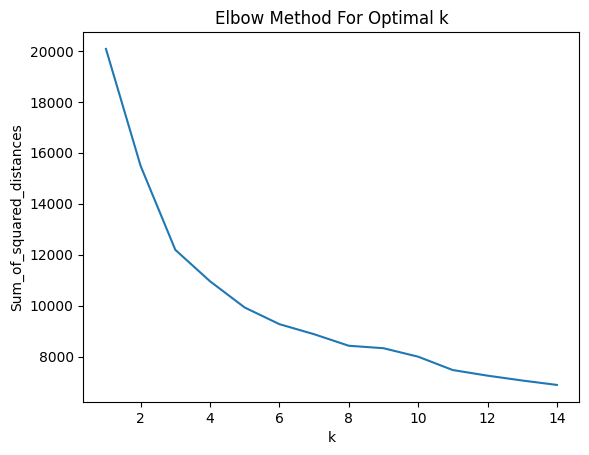

In [70]:
# Checking for optimal number of Clusters

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

Sum_of_squared_distances = []
K = list(range(1,15))
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', n_init=1, random_state=42)
    km.fit(embeddings)
    Sum_of_squared_distances.append(km.inertia_)
plt.figure()
plt.plot(K, Sum_of_squared_distances)
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


In [73]:
from sklearn.cluster import KMeans

num_clusters = 7  # Define the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

In [74]:
df['cluster'].value_counts()

,count
cluster,
2,102
0,101
6,71
3,68
5,63
4,53
1,42


In [80]:
df[df.cluster ==1].description

,description
45067,Not receiving some Outlook calendar invites. D...
8671,Both my Outlook and Teams are not letting me r...
24955,can't use new teams...using teams classic righ...
13018,My NUID(O384789) and password are not working ...
15848,"microsoft teams will not open, just screen tha..."
26301,receiving emails just fine but outgoing emails...
4625,I would like to remove 6 shared mailboxes from...
38068,"Reported Problem: ""Outlook cannot add the fold..."
36479,"Cannot log into Teams, receive this message: ""..."
14806,"When I click to open Teams app on my laptop, i..."


In [23]:
df[df.cluster ==5].description

,description
49879,cannot open teams
32254,I was given access to NCALKPLTCQuality@kp.org ...
512,**this is regarding the @AACC-EWorkforce email...
8323,Utterance:Office-365
27243,My teams is not working on this specific compu...
16846,issue? not able to move email to other ...
9968,The AMC Manager on-call phone number was not r...
36182,Mailbox set up error
9226,Utterance:Workstation B694987 INC19086398
9176,Need access to the following inbox: Careersat...
